
# Step 2 — EDA & Feature Engineering (with sklearn Pipeline)

**What this notebook does**
1. Load the Telco Churn dataset
2. Explore class balance and basic stats
3. Visualize numeric and categorical features
4. Engineer a few helpful features (e.g., tenure buckets, average monthly spend)
5. Build a **robust sklearn preprocessing pipeline** (OneHotEncoder + StandardScaler)
6. Split data with **stratify** to avoid single-class splits
7. Train a quick **Logistic Regression** and **Random Forest** to compare
8. Save the preprocessing+model **Pipeline** with `joblib` for later serving


In [1]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure plots display inline (if using Jupyter)
# %matplotlib inline

# Load dataset (place 'telco_churn_dataset.csv' in the same folder as this notebook)
csv_path = r"C:\Users\hussa\Downloads\telco_churn_dataset.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
df.head()


Shape: (500, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,nTGzL-10508,Female,0,Yes,No,10,Yes,No,Fiber optic,No,...,Yes,No,No,Yes,Month-to-month,No,Bank transfer (automatic),27.78,324.78,No
1,IKGEp-03908,Male,0,No,No,26,No,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,89.12,2321.10,No
2,iNJcX-57530,Female,0,No,Yes,8,No,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,22.87,209.92,Yes
3,vGjSn-43687,Female,0,No,Yes,47,No,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),93.73,4422.24,Yes
4,IVBce-67057,Male,0,Yes,No,55,Yes,Yes,DSL,No,...,Yes,No,No,No,Two year,Yes,Electronic check,102.31,5633.01,Yes


In [2]:

# Basic info and target balance
print(df.info())
print("\nChurn distribution:")
print(df['Churn'].value_counts())
print("\nChurn distribution (%):")
print((df['Churn'].value_counts(normalize=True) * 100).round(2))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        500 non-null    object 
 1   gender            500 non-null    object 
 2   SeniorCitizen     500 non-null    int64  
 3   Partner           500 non-null    object 
 4   Dependents        500 non-null    object 
 5   tenure            500 non-null    int64  
 6   PhoneService      500 non-null    object 
 7   MultipleLines     500 non-null    object 
 8   InternetService   500 non-null    object 
 9   OnlineSecurity    500 non-null    object 
 10  OnlineBackup      500 non-null    object 
 11  DeviceProtection  500 non-null    object 
 12  TechSupport       500 non-null    object 
 13  StreamingTV       500 non-null    object 
 14  StreamingMovies   500 non-null    object 
 15  Contract          500 non-null    object 
 16  PaperlessBilling  500 non-null    object 
 1

In [3]:

# Identify numeric vs categorical columns (before encoding)
numeric_cols_raw = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols_raw = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns (raw):", numeric_cols_raw)
print("Categorical columns (raw):", categorical_cols_raw)


Numeric columns (raw): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns (raw): ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


## Quick visualizations

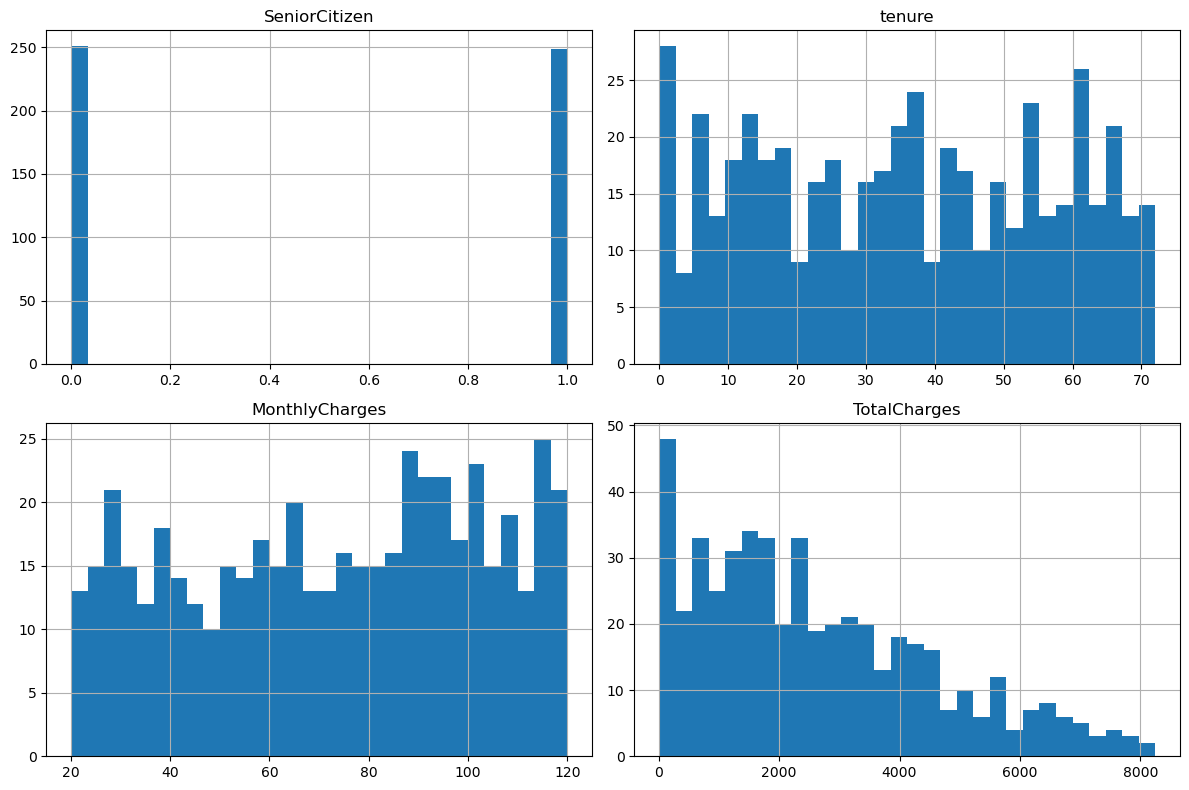

In [4]:

# Histogram for numeric columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
df[num_cols].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()


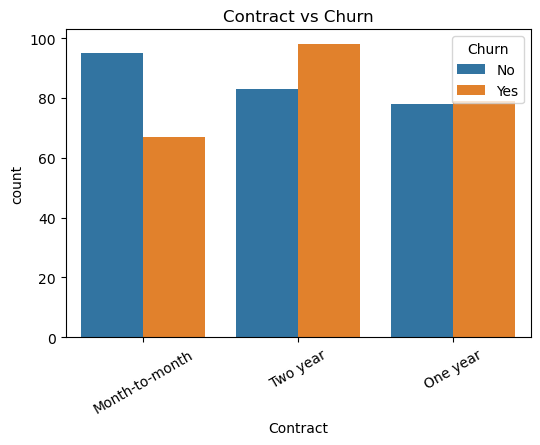

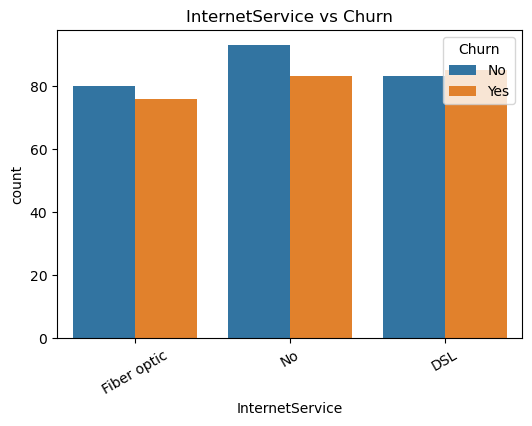

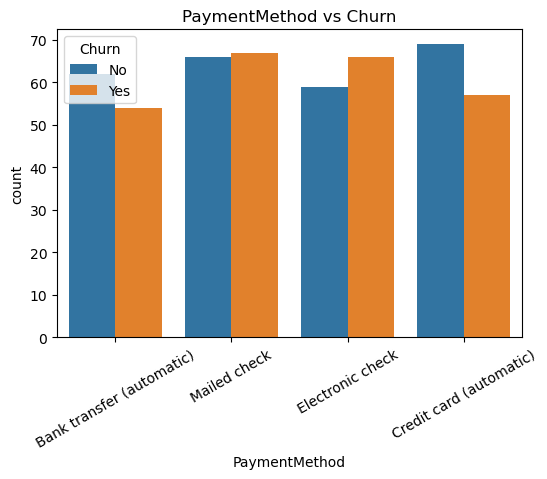

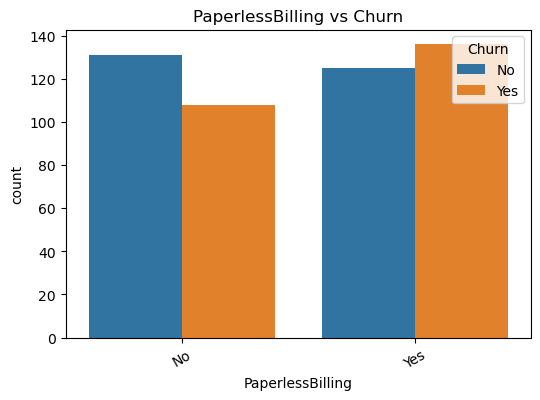

In [5]:

# Bar plots for a few key categoricals vs Churn
import seaborn as sns

sample_cats = [c for c in ['Contract','InternetService','PaymentMethod','PaperlessBilling'] if c in df.columns]
for col in sample_cats:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=30)
    plt.show()


## Feature Engineering

In [6]:

# Example engineered features

# 1) Tenure buckets
def tenure_bucket(t):
    if t < 12:
        return "0-12"
    elif t < 24:
        return "12-24"
    elif t < 48:
        return "24-48"
    else:
        return "48+"

if 'tenure' in df.columns:
    df['TenureBucket'] = df['tenure'].apply(tenure_bucket)

# 2) Average Monthly Spend (safe divide)
if 'TotalCharges' in df.columns and 'tenure' in df.columns and 'MonthlyCharges' in df.columns:
    df['AvgMonthlySpend'] = df.apply(lambda r: r['TotalCharges']/r['tenure'] if r['tenure']>0 else r['MonthlyCharges'], axis=1)

# 3) Count how many internet-related services are 'Yes'
internet_yes_cols = [c for c in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'] if c in df.columns]
def count_yes(row):
    cnt = 0
    for c in internet_yes_cols:
        v = row.get(c, "No")
        cnt += 1 if str(v).strip().lower() == "yes" else 0
    return cnt

if internet_yes_cols:
    df['InternetYesCount'] = df.apply(count_yes, axis=1)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureBucket,AvgMonthlySpend,InternetYesCount
0,nTGzL-10508,Female,0,Yes,No,10,Yes,No,Fiber optic,No,...,Yes,Month-to-month,No,Bank transfer (automatic),27.78,324.78,No,0-12,32.478000,2
1,IKGEp-03908,Male,0,No,No,26,No,No,No,No internet service,...,No internet service,Two year,No,Mailed check,89.12,2321.10,No,24-48,89.273077,0
2,iNJcX-57530,Female,0,No,Yes,8,No,No,No,No internet service,...,No internet service,Two year,No,Mailed check,22.87,209.92,Yes,0-12,26.240000,0
3,vGjSn-43687,Female,0,No,Yes,47,No,No,No,No internet service,...,No internet service,Two year,No,Bank transfer (automatic),93.73,4422.24,Yes,24-48,94.090213,0
4,IVBce-67057,Male,0,Yes,No,55,Yes,Yes,DSL,No,...,No,Two year,Yes,Electronic check,102.31,5633.01,Yes,48+,102.418364,2


## Build sklearn preprocessing pipeline

Categorical cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureBucket']
Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'InternetYesCount']

=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.53      0.55      0.54        51
           1       0.51      0.49      0.50        49

    accuracy                           0.52       100
   macro avg       0.52      0.52      0.52       100
weighted avg       0.52      0.52      0.52       100

ROC-AUC: 0.477


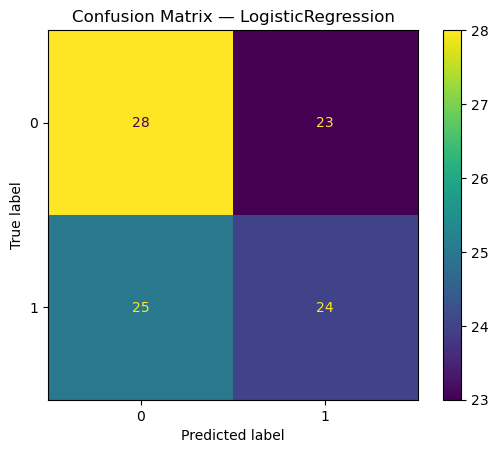


=== RandomForest ===
              precision    recall  f1-score   support

           0       0.45      0.41      0.43        51
           1       0.43      0.47      0.45        49

    accuracy                           0.44       100
   macro avg       0.44      0.44      0.44       100
weighted avg       0.44      0.44      0.44       100

ROC-AUC: 0.446


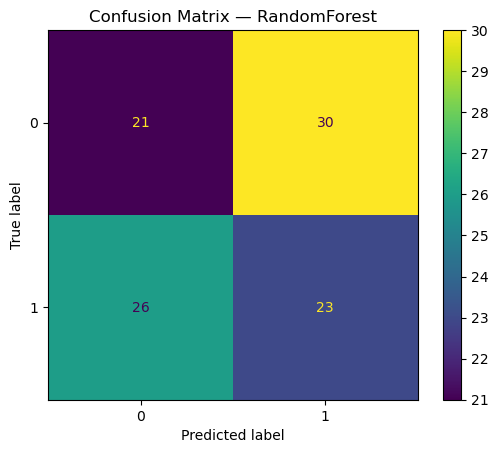


Best model: LogisticRegression (AUC=0.477)


In [7]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import joblib
from pathlib import Path

# Prepare target and drop ID-like columns
assert 'Churn' in df.columns, "Target 'Churn' missing"
y = (df['Churn'] == 'Yes').astype(int)

drop_cols = [c for c in ['customerID','Churn'] if c in df.columns]
X = df.drop(columns=drop_cols)

# Split with stratify to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify categorical vs numeric after feature engineering
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical cols:", categorical_cols)
print("Numeric cols:", numeric_cols)

# Preprocess: One-hot encode categoricals; scale numerics (benefits LR; RF is robust either way)
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

# Two models to compare quickly
logreg = Pipeline(steps=[('prep', preprocess),
                        ('model', LogisticRegression(max_iter=1000, solver='liblinear'))])

rf = Pipeline(steps=[('prep', preprocess),
                    ('model', RandomForestClassifier(n_estimators=300, random_state=42))])

models = {'LogisticRegression': logreg, 'RandomForest': rf}

results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_prob)
    results[name] = {'report': report, 'auc': auc, 'pipe': pipe}
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", round(auc, 3))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

# Pick best by AUC
best_name = max(results, key=lambda k: results[k]['auc'])
best_auc = results[best_name]['auc']
best_pipe = results[best_name]['pipe']

print(f"\nBest model: {best_name} (AUC={best_auc:.3f})")


In [8]:

# Save the best pipeline for later serving
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)
out_path = models_dir / "churn_best_pipeline.pkl"
joblib.dump(best_pipe, out_path)
out_path.resolve()


WindowsPath('C:/Users/hussa/Downloads/models/churn_best_pipeline.pkl')